In [1]:
using DifferentialEquations
using Plots
using LinearAlgebra
import ForwardDiff
import DiffResults
using AstrodynamicsBase
using Printf
using JSON
using CSV
using DataFrames
using ColorSchemes
using LaTeXStrings

In [2]:
include("../src/SailorMoon.jl")   # relative path to main file of module
param3b = SailorMoon.dynamics_parameters()
paramMulti = SailorMoon.multi_shoot_parameters(param3b)
gr()
fs = 16


┌ Warning: Replacing docs for `Main.SailorMoon.integrate_rk4 :: Union{Tuple{ODEProblem, Real}, Tuple{ODEProblem, Real, Union{Nothing, Vector}}, Tuple{ODEProblem, Real, Union{Nothing, Vector}, Bool}, Tuple{ODEProblem, Real, Union{Nothing, Vector}, Bool, Bool}}` in module `Main.SailorMoon`
└ @ Base.Docs docs\Docs.jl:240


16

In [3]:
function plot_circle(radius, x, y, n=100)
    circle = zeros(2,n)
    thetas = LinRange(0.0, 2π, n)
    for i = 1:n
        circle[1,i] = radius*cos(thetas[i]) + x
        circle[2,i] = radius*sin(thetas[i]) + y
    end
    return circle
end

plot_circle (generic function with 2 methods)

In [4]:
moon     = plot_circle((1-param3b.mu2)*param3b.lstar, 0.0, 0.0)
earth    = plot_circle(param3b.mu2*param3b.lstar, 0.0, 0.0)
earth_ub = plot_circle(param3b.mu2*param3b.lstar+6375,0.0, 0.0)
earth_lb = plot_circle(param3b.mu2*param3b.lstar-6375, 0.0, 0.0)
moon_soi_outer = plot_circle((1-param3b.mu2)*param3b.lstar+66000, 0.0, 0.0);

In [5]:
function interpolatecolor(cs,value, vmin, vmax)
    cs = cgrad(cs)
    color = cs[(value - vmin) / (vmax - vmin)]
    return color
end

interpolatecolor (generic function with 1 method)

In [6]:
### PARAMETERS ###################################
# csv file to load the initial solution
filename = "data/output_diffcorr2_0521.csv"
# dv_dir function corresponding to the csv file 
dir_func = SailorMoon.dv_EMrotdir_sb1frame 

n_arc = 5

cs = :lightrainbow 
##################################################

if dir_func == SailorMoon.dv_no_thrust
    τ_ig = 0.0
else 
    τ_ig = 1.0
end

# load initial guess
df = CSV.read(filename, DataFrame; header=0);

arcs_color = Dict(
    "xlr_bck_arc" => :blue, 
    "xlr_fwd_arc" => :blue,
    "mid_bck_arc" => :blue, 
    "mid_fwd_arc" => :blue, 
    "lpo_arc" => :blue
)


pcart = plot(
    size=(700,500), frame_style=:box, aspect_ratio=:equal, grid=0.4, legend=false, 
    xlabel=L"x, \times10^6\textrm{km}", ylabel=L"y, \times10^6\textrm{km}",
    colorbar_titlefontsize=fs,
    fontsize=fs, xlabelfontsize=fs, ylabelfontsize=fs, xtickfontsize=fs-1, ytickfontsize=fs-1, legendfontsize=fs-1
);

p_time = plot(
    size=(700,500), frame_style=:box, grid=0.4, legend=false, 
    xlabel=L"time, s", ylabel=L"value",
    colorbar_titlefontsize=fs,
    fontsize=fs, xlabelfontsize=fs, ylabelfontsize=fs, xtickfontsize=fs-1, ytickfontsize=fs-1, legendfontsize=fs-1
);

In [13]:

tofs= [row[1] for row in eachrow( df ) ] 
tof_max = maximum(tofs)
tof_min = minimum(tofs)

tof_max_days = tof_max * param3b.tstar / (24*60*60)
tof_min_days = tof_min * param3b.tstar / (24*60*60)

colors = [interpolatecolor(cs, row[1], tof_min, tof_max) for row in eachrow(df)]

for (i, row) in enumerate( eachrow( df ) ) 
    
    x = collect(values(row[3:end]))
#     println(x)
    
    color = colors[i]
    res, sol_param_list, sols_ballistic, tofs = SailorMoon.multishoot_trajectory2(x, dir_func, paramMulti, true, false)
        
    # ballistic legs
    for sol_ballistic in sols_ballistic
#         plot!(pcart, (hcat(sol_ballistic.u...)[1,:].- param3b.as) .* param3b.lstar, hcat(sol_ballistic.u...)[2,:].*param3b.lstar, c="blue", label=false)
        plot!(pcart, (hcat(sol_ballistic.u...)[1,:].- param3b.as) .* param3b.lstar, hcat(sol_ballistic.u...)[2,:].*param3b.lstar, c=color, label=false)

        if i == 1
#             println(length(sol[7,:]))
#             println(sol[7,:])
#             println(sol.t)
            scatter!(p_time, sol_ballistic.t[:],  sol_ballistic[7,:])
        end
   
    end
    
    for j = 1:length(sol_param_list)
        sol, _, name = sol_param_list[j]
        
#         plot!(pcart, (sol[1,:] .- param3b.as) .* param3b.lstar , sol[2,:].*param3b.lstar, c="blue")  # if ther is one trajectory, set a color manually
        plot!(pcart, (sol[1,:] .- param3b.as) .* param3b.lstar , sol[2,:].*param3b.lstar, c=color)
        
#         plot!(pcart, sol[1,:], sol[2,:], c=color)
#         scatter!(pcart, [sol[1,1],sol[1,end]], [sol[2,1],sol[2,end]], label=false, c=arcs_color[name], marker=:circle)
        
        if i == 1
#             println(length(sol[7,:]))
#             println(sol[7,:])
#             println(sol.t)
            scatter!(p_time, sol.t[:],  sol[7,:])
        end
        
    end
    
end


plot!(pcart, earth[1,:], earth[2,:], c=:green, lw=1.0, label="earth")
plot!(pcart, earth_ub[1,:], earth_ub[2,:], c=:black, lw=1.0, label="earth")
plot!(pcart, earth_lb[1,:], earth_lb[2,:], c=:black, lw=1.0, label="earth")
plot!(pcart, moon[1,:], moon[2,:], c=:orange, lw=1.0, label="moon")
plot!(pcart, moon_soi_outer[1,:], moon_soi_outer[2,:], c=:black, lw=1.0, label="moon_soi_outer",
    xaxis=(formatter=x->string(round(x / 10^6; digits=2))),
    yaxis=(formatter=y->string(round(y / 10^6; digits=1))),
)

pcart


[388.0175266943173, -0.39139900971305186, -0.11211116195476226, -1.0713763035049588, -0.5407123490906043, -0.10623310209607544, 1.035853599271437, 0.4661483114469939, 2.900614633554115, 0.9899933723014808, 0.003301744733559678, 0.0014326336798364807, 0.9899933699313048, 0.014141173628426547, -0.004350476763430044, 0.9899933628032236, -0.006441304770029327, -0.002170019349720004, 0.9899933587629246, -0.0005141254505908366, -0.0007949562659938575, 0.9899933545869586, -0.0008014016973827401, -0.00851223542944799, 0.9899998816798269, 0.13112746515133905, -0.18541551415403043, 0.9900188300948014, 0.23349262031998314, -0.4387365405176768, 0.9900361040078194, 0.29195145288387253, -0.5578917321322523, 0.9900516081782892, 0.29311312466186856, -0.6227513170174116, 0.990065547743996, 0.21573734769279207, -0.6899272809152692, 386.07774910896063, -0.0025077278214881895, -0.07648487320078644, -0.022715668343143758, 0.0038605250685115576, 0.003808329872223724, 1.0217141022613372, 2.926113207748883, 6

[388.01130180811583, -0.3611229517329418, -0.12089749843006412, -1.0819092788936102, -0.524586328870223, -0.10562956673015167, 1.035255350660211, 0.4616038071849418, 2.8631789207905363, 0.9899512604113724, 0.003360137758477713, 0.0014276619260769178, 0.9899512238190546, 0.014182117915321835, -0.004356009415238752, 0.9899511694585503, -0.006413497448947334, -0.002172393355974363, 0.9899511186246636, -0.0005011155629057432, -0.0007970280655399481, 0.9899510791733488, -0.000797820927253578, -0.008513168158738491, 0.989972738301592, 0.13154940257096806, -0.18571062240581382, 0.9900023209513774, 0.23374865818344362, -0.43922498557186673, 0.9900110155547452, 0.2918321573656456, -0.5583882587146667, 0.9900187770099574, 0.29288418050053927, -0.6231980572380794, 0.9900256810273544, 0.21630626870884984, -0.6901925012215273, 386.0845052739897, -0.002379447150707886, -0.07653150985511474, -0.02109850371835908, -0.0009990228245337137, 0.005154527292531238, 1.0213387387998367, 2.8718964331869086, 6.

[388.00494695422236, -0.32476270148655617, -0.1309867785887854, -1.098737369098398, -0.4984391304731189, -0.1075288414597193, 1.0345398961702281, 0.45648336640804354, 2.8183117703296987, 0.989893855421815, 0.0034371577278396086, 0.0014187424351105008, 0.9898937619818059, 0.014236456472790747, -0.004362871595669288, 0.9898936226587621, -0.006379085079486436, -0.0021769390784505366, 0.9898935242316192, -0.000483817804423677, -0.0007991910152710215, 0.9898934226955837, -0.0007935057985074186, -0.008513481811555446, 0.9899371785741482, 0.1320857497549207, -0.1860389920314974, 0.9900054391634402, 0.23410348520848065, -0.43978130280458255, 0.9900142941343051, 0.29174795480100424, -0.558957997131173, 0.9900221934520835, 0.29267307730795017, -0.6237068187211007, 0.9900292312613672, 0.2170502287266144, -0.6904840637993113, 386.09381337698153, -0.002222709917832338, -0.0765282879210009, -0.01914534990760087, -0.00713779164482704, 0.006826846411268211, 1.020890016200485, 2.806844909496121, 5.9326

[387.99923555223864, -0.2879037953064196, -0.14088534722071872, -1.1165979153498202, -0.46818889524162427, -0.11003446619046443, 1.0338237546560223, 0.45164504774535774, 2.773706420605906, 0.9898405793357437, 0.003519881412568482, 0.0014094074615871412, 0.989840416038643, 0.014295247984194919, -0.004369168735435844, 0.9898401811391124, -0.006342683928049572, -0.0021809203219006435, 0.9898400181283392, -0.0004659160847130464, -0.0008017636465668557, 0.9898398389091931, -0.0007891311991991676, -0.00851372129355281, 0.9899063254418164, 0.13265641292943262, -0.18636126864867436, 0.990006491609975, 0.2345045083885574, -0.4403252882606965, 0.9900158334924481, 0.291700099139887, -0.5595153567050586, 0.99002417849873, 0.29249491108524994, -0.6242007570374382, 0.9900316177334072, 0.2178602772657833, -0.6907601202963052, 386.1042303414438, -0.002061462080772461, -0.0765765892098227, -0.01723697257330452, -0.013607121537855467, 0.008572479429586737, 1.02043977032519, 2.741880789313202, 5.83351063

[387.99416716563456, -0.2503750174724938, -0.15075079809841033, -1.134235495001829, -0.43455157450104503, -0.1127474460046235, 1.033106674133128, 0.44723481173173324, 2.7295600277802987, 0.9897758947853146, 0.0036108445496686676, 0.0013987881721395014, 0.9897756448333594, 0.014359467059653238, -0.004375613049257563, 0.9897752908349584, -0.006301725873219704, -0.0021861586462614954, 0.9897750297287803, -0.0004456896744211801, -0.0008035646497390621, 0.9897747575431759, -0.0007836638426365092, -0.008514040941559713, 0.9898669367659649, 0.13329384104655922, -0.18668206822338718, 0.9900083565668515, 0.23495999817598412, -0.4408599092401731, 0.9900186184259162, 0.2916654559033461, -0.5600556011371249, 0.9900278241996642, 0.29231738548873276, -0.6246733881702513, 0.9900360007996463, 0.21873593596539925, -0.6910085797698229, 386.11559519743116, -0.0018941439298616766, -0.0768168347621154, -0.015460890533263794, -0.02035431842575285, 0.010417786947210024, 1.0199871184078704, 2.677058515464118,

[387.9898266565609, -0.2121942917565541, -0.16080933336973996, -1.150955703506761, -0.39748634438954655, -0.11562987624240426, 1.032388039051101, 0.44352159442198724, 2.68607033568087, 0.9897195282810461, 0.003711692541296243, 0.0013838161645318352, 0.9897191824156645, 0.014430382575769663, -0.004386134452116971, 0.9897186708382433, -0.006257661887217818, -0.0021930558031805054, 0.9897182863605604, -0.00042404712409336003, -0.0008067570145707259, 0.9897178897411159, -0.0007788951824697904, -0.008514559422569266, 0.9898411703055557, 0.13404935313057603, -0.1870116687565219, 0.9900080621941224, 0.23549072101954577, -0.4414010305453089, 0.9900202876855884, 0.2916198188752416, -0.560597110020362, 0.9900311852299918, 0.292097604986271, -0.6251360556394363, 0.9900408887414742, 0.21968946947579007, -0.6912338736148509, 386.1275278410774, -0.0017176664075458689, -0.0774811378911333, -0.013948651835893807, -0.0272320478018314, 0.012415196953853895, 1.019530978632551, 2.6123695760344465, 5.63242

[387.98616131470965, -0.1737321932435054, -0.17152758987267935, -1.1660527718579918, -0.3565047405520799, -0.11881392483501949, 1.0316671160612856, 0.44097976193486366, 2.6434548618344342, 0.9896615713932662, 0.0038368263646100984, 0.001369072663785719, 0.9896610659400804, 0.01451824530739636, -0.0043961545352531085, 0.9896603402487247, -0.006201561261306596, -0.0021984653167445817, 0.9896597716693137, -0.000396422019208351, -0.0008099807093690509, 0.9896591917568658, -0.000772095752293612, -0.008514555356309489, 0.9898246630491575, 0.13500679165275697, -0.18737772528264104, 0.9900147604119635, 0.23613053451618662, -0.4419797536575917, 0.9900305816866763, 0.29151292363369463, -0.5611638449056586, 0.9900446774317216, 0.29175240964295274, -0.6256018556353468, 0.9900572427853926, 0.2207581389663821, -0.69143400565154, 386.1391805280328, -0.0015257217636770273, -0.07902965490916783, -0.012913403741787103, -0.033879037998243766, 0.01468051404980383, 1.0190703947550663, 2.5476413384254326, 5

[387.98313396250046, -0.1424131906244553, -0.1817808774368871, -1.1765120766817412, -0.3183454548991446, -0.12196870994287753, 1.0310634362679312, 0.44049320645511775, 2.6087818301554964, 0.9896197217268135, 0.003977000275005578, 0.0013527100847388945, 0.9896189856697145, 0.014616459751718516, -0.004406814123762452, 0.9896180063228052, -0.006140440720394319, -0.0022032870424214257, 0.9896172105124827, -0.0003657546139231785, -0.0008116155502021209, 0.9896163839607796, -0.0007647769928816877, -0.008514013570878125, 0.98983515236312, 0.13610444799557508, -0.18775201447138498, 0.9900311523963621, 0.23680235497164814, -0.4425493788387289, 0.9900534436991169, 0.29127531989901473, -0.5617100829875672, 0.9900733244811755, 0.291206620756806, -0.6260276981512324, 0.9900910866257321, 0.22178307464427147, -0.6915867647613954, 386.1471030508553, -0.0013427725287623539, -0.08177476928383075, -0.012730031113554821, -0.038555060736137785, 0.016977150943609, 1.0186826525577453, 2.4931839441723302, 5.4

[387.9176784826741, -0.11055481926299301, -0.2085553601609002, -1.1625774900517465, -0.14300441763642086, -0.10734465894332307, 1.026733169009757, 0.488874034777964, 2.6072932375753317, 0.5006696535498759, 0.05643550668335665, -0.008522703131838906, 0.5004663410210263, 0.04232273455253421, -0.008163371121175034, 0.5003504539576118, 0.021990677966455548, -0.006091064647342515, 0.5002160197327392, 0.009587259579831232, -0.002913012092775055, 0.5001713557223939, 0.0021629705857781714, -0.0026811732050362014, 0.5918615606071645, 0.2284764828743004, -0.16531852491112203, 0.7087572904721087, 0.18778828162375585, -0.273444679435718, 0.776242423820451, 0.1837244483123707, -0.3341261827859794, 0.816946610810123, 0.1880457585793802, -0.3827041835178525, 0.8432944792701978, 0.19591355485028586, -0.4188962774107654, 385.9943419403568, 0.00012069170182702765, -0.0979871447916712, -0.039795714968056124, 0.017920398823775687, 0.03345391556535651, 1.017005850863724, 2.361243410583735, 5.85028477103288

[387.9056793000909, -0.10786005729759693, -0.19274156644623103, -1.156861671384755, -0.12962664263541873, -0.09709872385098213, 1.0268781317400357, 0.4930144909401808, 2.581824137168439, 0.5006854955696767, 0.07208278281824015, -0.008887089344304223, 0.5004496460834099, 0.05054648441126249, -0.006730253759976307, 0.5002580225040167, 0.030087979029878, -0.0042130237746821906, 0.5001355554943354, 0.014041910403189587, -0.0017136908299753137, 0.5000424284549143, 0.0029805128661377343, -0.0006707923349804617, 0.6111451386399337, 0.2492162399637547, -0.1634131307992222, 0.7410195395638871, 0.1910897770207853, -0.2469375416933883, 0.8079718865823349, 0.1839958737913463, -0.3007055079085894, 0.8458599749170674, 0.18988694129094164, -0.3439440981471583, 0.8696611220548348, 0.19342886621327554, -0.3770385681234211, 386.01454224549815, 0.00013509125005742228, -0.09072905006126365, -0.0356253199613028, 0.01041571618973654, 0.0306634847120402, 1.0168860496226126, 2.347155797952491, 5.7589752475447

[387.8786237873742, -0.10812576040162089, -0.15901668529633214, -1.1384494238201794, -0.1216174529608658, -0.07721125678657387, 1.0271965460609704, 0.5067329289302003, 2.563708440929166, 0.5015787694843212, 0.1291267031126397, -0.01498471446587312, 0.5008882362103448, 0.09187305485539735, -0.009656362459536317, 0.5003979546420944, 0.05614266469592679, -0.005238638254043921, 0.5001986015200723, 0.027481101527760506, -0.0023878580233036035, 0.500039737210717, 0.0056154234185299785, -0.00045642785083859416, 0.6643899090014986, 0.29977918052885844, -0.1805269645743568, 0.8072731602577056, 0.20459051171375695, -0.22709490555805392, 0.8646725443984806, 0.18735477619898996, -0.2586184155822924, 0.8939076634246622, 0.18456045664945023, -0.28462959934106596, 0.9113623677535437, 0.18524942669299824, -0.3065489520196764, 386.0408986653886, 4.878638940610211e-5, -0.07293358574993808, -0.025614176937410194, -0.0055654609701004006, 0.02557944390605556, 1.0166552801940496, 2.3527751308109472, 5.53844

[387.84865518726895, -0.10300313695971523, -0.12076816088523001, -1.1201421175443667, -0.08398354236508002, -0.055447194115474156, 1.0274657056082184, 0.5240450902331107, 2.5049339790012795, 0.5021477509425243, 0.13291051393962142, -0.01537609681376355, 0.5012549867518409, 0.09447498269194086, -0.009956914389050971, 0.500584791782989, 0.057750590682735, -0.005368538365190144, 0.5002524787428427, 0.02829917311911292, -0.0024903135704017437, 0.5000579034003905, 0.0058503283180358625, -0.0004265816584732099, 0.7197088118824733, 0.3076984773547438, -0.18203849138103112, 0.8776969668839955, 0.20828109040831738, -0.22667791403405466, 0.9247306031151731, 0.1898818750640962, -0.25688558112730425, 0.9449261904221121, 0.18605609867237874, -0.28176098980959347, 0.9558179247234669, 0.18601249172187187, -0.3030457458610749, 386.0743505862549, 0.00017770267113298273, -0.05405136766828483, -0.02438583713183891, -0.010705380419065286, 0.01945671219412029, 1.016642061040091, 2.281771917594947, 5.426191

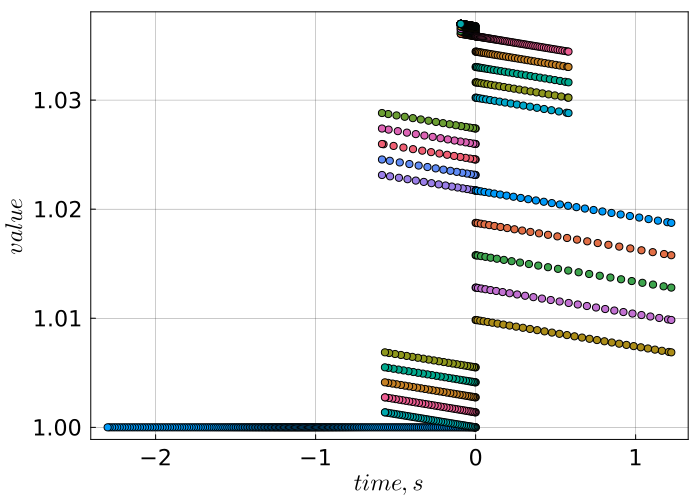

In [10]:
p_time

### Focus on the vicinity to the Earth 

In [ ]:
plot!(pcart; xlims=[-0.05, 0.05].*10^6, ylims=[-0.05,0.05].*10^6)


In [ ]:
l = @layout [a{0.92w} b{0.03w}]

p2 = heatmap(rand(2,2), clims=(tof_min_days, tof_max_days),
    framestyle=:none, c=cs, cbar=true, lims=(-1,0), colorbar_title="\nToF, days",
    colorbar_titlefontsize=fs,
    colorbar_tickfontsize=fs-1,
    fontsize=fs, xlabelfontsize=fs, ylabelfontsize=fs, xtickfontsize=fs-1, ytickfontsize=fs-1, legendfontsize=fs-1,
    thickness_scaling = 1.6,
    )

plot(pcart, p2, layout=l, size=(900,500), 
#     top_margin=5Plots.mm,
#     right_margin=5Plots.mm,
#     left_margin=5Plots.mm, 
    bottom_margin=5Plots.mm, 
#     title=["No thrust" "Earth-Moon rotating thrust" ""]
    )

savefig("traj_family.png")
